# Code Stub for COMP7220/8220 major project.
Released 17/3/23. 
v 1.00

Link to Google Drive, assuming you have stored dataset there.

Load the test data

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Your file will probably be called this, if you used the regular Kaggle download. 
!unzip -q /gdrive/MyDrive/23comp8220/living-thing-classification-coarse.zip     # CHANGE DIRECTORY

In [ ]:
!ls -alh public

total 31M
drwxr-xr-x 5 root root 4.0K Mar 13 06:06 .
drwxr-xr-x 1 root root 4.0K Mar 13 06:06 ..
-rw-r--r-- 1 root root 1.3K Mar 11 06:52 info.json
drwxr-xr-x 2 root root 7.0M Mar 13 06:05 test
-rw-r--r-- 1 root root 2.5M Mar 11 06:52 test.csv
drwxr-xr-x 2 root root 7.5M Mar 13 06:06 train
-rw-r--r-- 1 root root 4.8M Mar 11 06:56 train.csv
drwxr-xr-x 2 root root 7.0M Mar 13 06:06 val
-rw-r--r-- 1 root root 2.4M Mar 11 07:00 val.csv


In [ ]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
batch_size = 64
img_size = 112
fine_grain = False
num_classes = 50 if fine_grain else 8

root = Path('/content/public')

Some potentially useful functions for reading data from files.

In [ ]:
def load_target_names(path='public/info.json'):
    with open(path) as f:
        info = json.load(f)
    return info['fine'], info['coarse']

def load_image(file_path, image_size=112):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [image_size, image_size])
    return img

def create_dataset_tf(split, fine_grained, batch_size=32, image_size=112):
  df = pd.read_csv(root / f"{split}.csv")
  file_paths = df.filename.map(lambda fn: str(root / split / fn))
  labels = df.fine if fine_grained else df.coarse

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.map(lambda x, y: (load_image(x, image_size=image_size), y))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  return dataset


def create_dataset_sklearn(split, fine_grained, image_size=48, percent=0.1):
  dataset = create_dataset_tf(split=split, fine_grained=fine_grained, batch_size=1000, image_size=image_size)
  dataset = dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
  X = None
  Y = None
  n_batches = int(len(dataset) * percent)
  for x,y in dataset.take(n_batches):
    x, y = x.numpy(), y.numpy()
    x = x.reshape(x.shape[0], -1)
    X = x if X is None else np.vstack([X, x])
    Y = y if Y is None else np.hstack([Y, y])

  return X, Y




In [ ]:
fine_names, coarse_names = load_target_names()
print(coarse_names)

['Aves', 'Reptilia', 'Mammalia', 'Arachnida', 'Magnoliopsida', 'Insecta', 'Liliopsida', 'Pinopsida']


In [ ]:
print(fine_names)

['Scolopacidae', 'Laridae', 'Accipitridae', 'Anatidae', 'Corvidae', 'Icteridae', 'Picidae', 'Colubridae', 'Sciuridae', 'Rosaceae', 'Cyperaceae', 'Brassicaceae', 'Sphingidae', 'Orchidaceae', 'Apidae', 'Papilionidae', 'Orobanchaceae', 'Liliaceae', 'Apocynaceae', 'Poaceae', 'Araneidae', 'Pinaceae', 'Asparagaceae', 'Acrididae', 'Hesperiidae', 'Rubiaceae', 'Onagraceae', 'Libellulidae', 'Fagaceae', 'Cactaceae', 'Lycaenidae', 'Coenagrionidae', 'Boraginaceae', 'Ranunculaceae', 'Polygonaceae', 'Pieridae', 'Caryophyllaceae', 'Lamiaceae', 'Noctuidae', 'Apiaceae', 'Malvaceae', 'Geometridae', 'Plantaginaceae', 'Euphorbiaceae', 'Crambidae', 'Parulidae', 'Erebidae', 'Ericaceae', 'Passerellidae', 'Tyrannidae']


Creating datatsets for sklearn (along with showing some images, so you can see what they're like).

In [ ]:
X,Y = create_dataset_sklearn('train', fine_grained=False)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


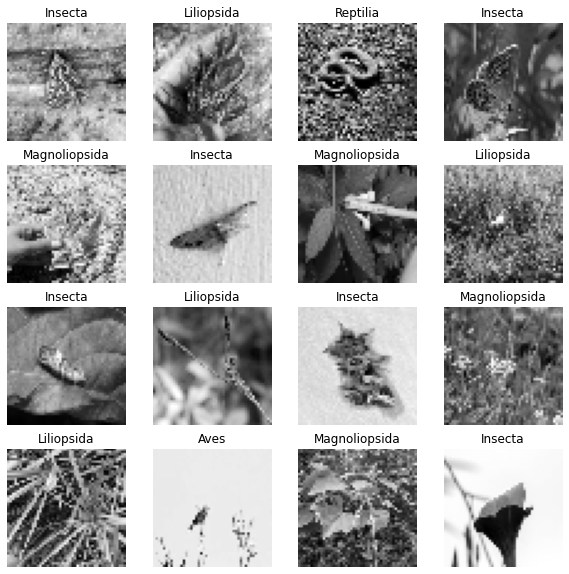

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(X[i].reshape(48,48), cmap='gray')
  if fine_grain:
    plt.title(fine_names[Y[i]])
  else:
    plt.title(coarse_names[Y[i]])
  plt.axis("off")
plt.show();

Creating datasets for TensorFlow.

In [ ]:
train_ds = create_dataset_tf('train', fine_grained=fine_grain, batch_size=batch_size)
val_ds = create_dataset_tf('val', fine_grained=fine_grain, batch_size=batch_size)

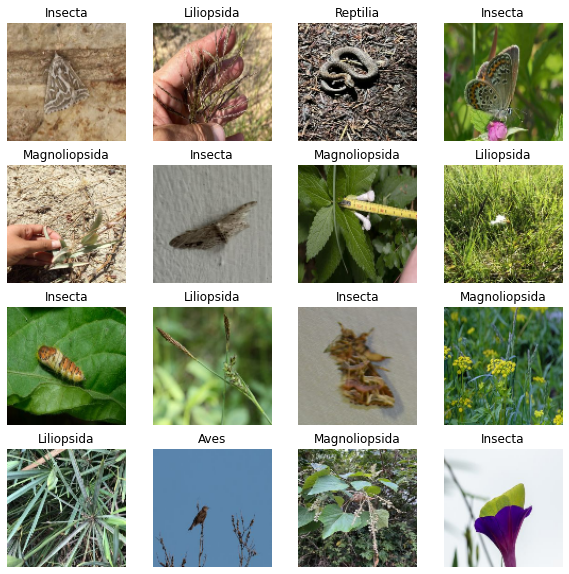

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy())
    if fine_grain:
      plt.title(fine_names[labels[i]])
    else:
      plt.title(coarse_names[labels[i]])
    plt.axis("off")
plt.show();

Your models in here ...

Load the test data

In [ ]:
# Choose one of these, depending on whether you're building sklearn or keras models
X_test, Y_test = create_dataset_sklearn('test', fine_grained=False, fraction=1.0) # make sure to use all of the test set for sklearn
test_ds = create_dataset_tf('test', fine_grained=fine_grain, batch_size=batch_size)

Saving predictions to csv file for Kaggle.

In [ ]:
# This is just making up a vector of predictions.  You should use the predictions of your models.
N = 50000     # num elements in test.csv
y_pred = [0] * N  # set all predicted labels to 0

In [ ]:
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:,"coarse"] = y_pred
test_csv = test_csv.drop(columns=['fine'])
pred_file = "/gdrive/MyDrive/23comp8220/my_test_preds.csv"  # CHANGE DIRECTORY, FILENAME as appropriate
test_csv.to_csv(pred_file)